In [1]:
import h5py
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from utils import SegmentGenerator, setup_tf, build_unet

In [2]:
save_path = 'PATH_TO_LOADED_DATA.h5'

network_path = 'PATH_TO_NETWORK_WEIGHTS.h5'

fs = 200
n_secs = 30
n_channels = 18

In [3]:
setup_tf()

1 Physical GPUs,  1 Logical GPUs


# Loading data

In [4]:
with h5py.File(save_path, 'r') as f:
    file_names = []
    labels = []
    signals = []
    
    file_names_ds = f['filenames']
    signals_ds = f['signals']
    labels_ds = f['labels']
    
    for i in range(len(signals_ds)):
        file_names.append(file_names_ds[i])
        data = np.asarray(np.vstack(signals_ds[i]), dtype=np.float32).T
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        signals.append((data-mean)/std)
        labels.append(labels_ds[i])

### Detecting seizure containing recordings

In [5]:
seizure_label = []
for label in labels:
    seizure_label.append(np.sum(label)>0)
seizure_label = np.asarray(seizure_label, dtype=np.uint8)

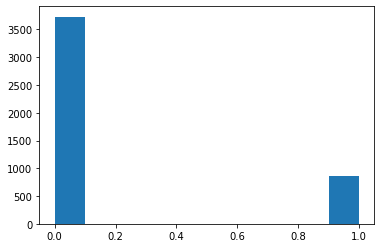

In [6]:
plt.hist(seizure_label);

### Train - validation split

In [7]:
signal_train, signal_val, label_train, label_val = model_selection.train_test_split(signals, labels,
                                 test_size=0.2, random_state=1337, stratify=seizure_label)

# Generator

# U-Net

In [8]:
n_filters = 8
window_size = 4096
n_channels = 18

In [9]:
unet, unet_train = build_unet(window_size=window_size, n_channels=n_channels, n_filters=n_filters)

In [10]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4096, 18)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4096, 18, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4096, 18, 8)  128         reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4096, 18, 8)  32          conv2d[0][0]                     
______________________________________________________________________________________________

# Training

In [11]:
generator = SegmentGenerator(signals=signal_train, labels=label_train, batch_size=32,
                             window_size=window_size, stride=1000, n_channels=n_channels)

In [12]:
n_batches = len(generator)
n_epochs = 100
optimizer = Adam(lr=1e-4)

loss_train = np.zeros(shape=(n_epochs,))
xentr_train = np.zeros(shape=(n_epochs,))
xentr_val_mean = np.zeros(shape=(n_epochs,))
xentr_val_std = np.zeros(shape=(n_epochs,))
one = np.float32(1.)
bin_xent = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.2)

best_loss = 1e20

In [13]:
all_labels = np.copy(np.concatenate(label_train))
n_bckg = np.sum(all_labels==0)
n_seiz = np.sum(all_labels==1)
del all_labels

In [14]:
for epoch in range(n_epochs):
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_xentr_avg = tf.keras.metrics.Mean()
    print('====== Epoch #{0:3d} ======'.format(epoch))
    for batch in range(n_batches):
        x, y = generator.__getitem__(batch)
        
        with tf.GradientTape() as t:
            y_0, y_1, y_2, y_3, y_4, y_5 = unet_train(x, training=True)
            xentr0 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_0, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))
            y = y[:, ::4]
            xentr1 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_1, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))
            y = y[:, ::4]
            xentr2 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_2, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))
            y = y[:, ::4]
            xentr3 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_3, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))
            y = y[:, ::4]
            xentr4 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_4, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))
            y = y[:, ::4]
            xentr5 = bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_5, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y))

            loss0 = tf.reduce_mean(xentr0)
            loss1 = tf.reduce_mean(xentr1)
            loss2 = tf.reduce_mean(xentr2)
            loss3 = tf.reduce_mean(xentr3)
            loss4 = tf.reduce_mean(xentr4)
            loss5 = tf.reduce_mean(xentr5)
            loss = loss0 + 0.2*(loss1 + loss2 + loss3 + loss4 + loss5)
            
        grad = t.gradient(loss, unet_train.trainable_variables)
        optimizer.apply_gradients(zip(grad, unet_train.trainable_variables))
        epoch_loss_avg(loss)
        epoch_xentr_avg(loss0)
    
    generator.on_epoch_end()
    
    xentr_train[epoch] = epoch_xentr_avg.result()
    loss_train[epoch] = epoch_loss_avg.result()
    print('Loss Train     - {0:.4f}'.format(loss_train[epoch]))
    print('Xentropy Train - {0:.4f}'.format(xentr_train[epoch]))
    
    xentr = []
    for j in range(len(signal_val)):
        signal = signal_val[j]
        label = label_val[j]
        if len(signal) < window_size:
            break
        x = []
        y = []
        for i in range(len(signal)//window_size):
            x.append(signal[window_size*i:(i+1)*window_size, :])
            y.append(label[window_size*i:(i+1)*window_size])
        x = np.asarray(x, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        y_ = unet.predict(x)
        xentr.append(bin_xent(y_true=tf.expand_dims(y, axis=-1), y_pred=tf.expand_dims(y_, axis=-1),
                             sample_weight=n_bckg/n_seiz*y+(one-y)).numpy())
        
    xentr_val_mean[epoch] = np.mean(xentr)
    xentr_val_std[epoch] = np.std(xentr)
    
    if xentr_val_mean[epoch] < best_loss:
        best_loss = xentr_val_mean[epoch]
        unet.save_weights(network_path)
    
    print('Xentropy Val   - {0:.4f} ± {1:.4f}'.format(xentr_val_mean[epoch], xentr_val_std[epoch]))

====== Epoch #  0 ======


KeyboardInterrupt: 

In [ ]:
plt.plot(xentr_train)
plt.plot(xentr_val_mean)

# Performance

In [ ]:
unet.load_weights(network_path)

In [ ]:
y_probas = []
y_trues = []
y_probas_pp = []
for j in range(len(signal_val)):
    signal = signal_val[j]
    label = label_val[j]
    if len(signal) < window_size:
        break
    x = []
    y = []
    for i in range(len(signal)//window_size):
        x.append(signal[window_size*i:(i+1)*window_size, :])
        y.append(label[window_size*i:(i+1)*window_size])
    x = np.asarray(x, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    y_ = unet.predict(x)
    y_probas.append(y_.flatten())
    y_trues.append(y.flatten())
    y_probas_pp.append(np.convolve(y_.flatten(), np.ones((400,))/400, mode='same'))

In [ ]:
thres = 0.5

In [ ]:
y_true = np.concatenate(y_trues)
y_proba = np.concatenate(y_probas)
y_pred = y_proba>thres

auc = metrics.roc_auc_score(y_true=y_true, y_score=y_proba)
acc = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
f1 = metrics.f1_score(y_true=y_true, y_pred=y_pred)
rec = metrics.recall_score(y_true=y_true, y_pred=y_pred)
prec = metrics.precision_score(y_true=y_true, y_pred=y_pred)
sens = rec
spec = metrics.recall_score(y_true=y_true==0, y_pred=y_pred==0)

y_proba_pp = np.concatenate(y_probas_pp)
y_pred_pp = y_proba_pp>thres

auc_pp = metrics.roc_auc_score(y_true=y_true, y_score=y_proba_pp)
acc_pp = metrics.accuracy_score(y_true=y_true, y_pred=y_pred_pp)
f1_pp = metrics.f1_score(y_true=y_true, y_pred=y_pred_pp)
rec_pp = metrics.recall_score(y_true=y_true, y_pred=y_pred_pp)
prec_pp = metrics.precision_score(y_true=y_true, y_pred=y_pred_pp)
sens_pp = rec_pp
spec_pp = metrics.recall_score(y_true=y_true==0, y_pred=y_pred_pp==0)

In [ ]:
print("========== RESULTS ==========")
print("----------   RAW   ----------")
print("AU-ROC      - {0:.4f}".format(auc))
print("Accuracy    - {0:.4f}".format(acc))
print("F1          - {0:.4f}".format(f1))
print("Recall      - {0:.4f}".format(rec))
print("Precision   - {0:.4f}".format(prec))
print("Sensitivity - {0:.4f}".format(sens))
print("Specificity - {0:.4f}".format(spec))
print('')
print("----------  w/ PP  ----------")
print("AU-ROC      - {0:.4f}".format(auc_pp))
print("Accuracy    - {0:.4f}".format(acc_pp))
print("F1          - {0:.4f}".format(f1_pp))
print("Recall      - {0:.4f}".format(rec_pp))
print("Precision   - {0:.4f}".format(prec_pp))
print("Sensitivity - {0:.4f}".format(sens_pp))
print("Specificity - {0:.4f}".format(spec_pp))